In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras

from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten, Dropout

C:\Users\chara\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


#### Reading the data

In [2]:
df = pd.read_csv('shuffled-full-set-hashed.csv',names = ["label", "words"])

#### EDA

In [3]:
print(df.shape)
df.head()

(62204, 2)


,label,words
0,DELETION OF INTEREST,e04a09c87692 d6b72e591b91 5d066f0246f1 ed41171...
1,RETURNED CHECK,a3b334c6eefd be95012ebf2b 41d67080e078 ff1c26e...
2,BILL,586242498a88 9ccf259ca087 54709b24b45f 6bf9c0c...
3,BILL,cd50e861f48b 6ca2dd348663 d38820625542 f077614...
4,BILL,9db5536263d8 1c303d15eb65 3f89b4673455 b73e657...


In [4]:
df.describe().T

,count,unique,top,freq
label,62204,14,BILL,18968
words,62159,60176,bf064c332aa1 079935e500e5 1a4dd36c6de0 7efa289...,11


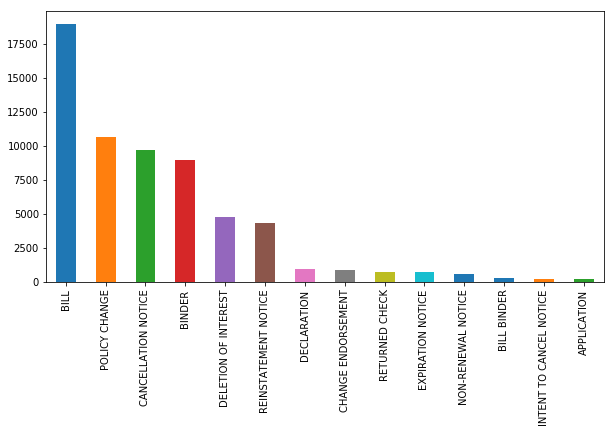

In [5]:
# Bar graph for labels
df['label'].value_counts().plot(kind='bar', figsize=(10,5))
plt.show()

In [6]:
# # Check for null values
df.isnull().sum()

label     0
words    45
dtype: int64

In [7]:
# Drop the null values
df.dropna(inplace=True)
df.shape

(62159, 2)

In [8]:
X = df['words']
y = df['label']

In [9]:
# Encoding the labels

# from sklearn import preprocessing
# le = preprocessing.LabelEncoder()
# y = le.fit_transform(y)

y_ = pd.get_dummies(y)
y_.shape

(62159, 14)

In [10]:
y_.columns

Index(['APPLICATION', 'BILL', 'BILL BINDER', 'BINDER', 'CANCELLATION NOTICE',
       'CHANGE ENDORSEMENT', 'DECLARATION', 'DELETION OF INTEREST',
       'EXPIRATION NOTICE', 'INTENT TO CANCEL NOTICE', 'NON-RENEWAL NOTICE',
       'POLICY CHANGE', 'REINSTATEMENT NOTICE', 'RETURNED CHECK'],
      dtype='object')

In [11]:
# seed = 10
# validation_size = 0.20
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=validation_size, random_state=seed)

In [12]:
## Encoded split
seed = 10
validation_size = 0.20
X_train, X_test, y_train, y_test = train_test_split(X, y_, test_size=validation_size, random_state=seed)

#### Vectorizing using TF-IDF

In [13]:
# Convert a collection of raw documents to a matrix of TF-IDF features.
# max_features has been set to overcome the computing issues
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=10000)
X_train = vectorizer.fit_transform(X_train.values)
X_test = vectorizer.transform(X_test.values)

#### Evaluating various Models

In [19]:
def evaluate(X, y, clf=None):
    probas = cross_val_predict(clf, X, y, cv=StratifiedKFold(n_splits=5, random_state=8), 
                              n_jobs=-1, method='predict_proba', verbose=2)
    pred_indices = np.argmax(probas, axis=1)
    classes = np.unique(y)
    preds = classes[pred_indices]
    print('Log loss: {}'.format(log_loss(y, probas)))
    print('Accuracy: {}'.format(accuracy_score(y, preds)))

In [24]:
# Logistic Regression
evaluate(X_train, y_train, clf=LogisticRegression())

[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   39.8s remaining:   59.8s


Log loss: 0.48781628295878415
Accuracy: 0.8536006596014237


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   48.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   48.7s finished


In [31]:
# Adaboost Classifier
evaluate(X_train, y_train, clf=AdaBoostClassifier())

[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.3min remaining:  1.9min


Log loss: 2.4238816827374245
Accuracy: 0.5713797333440586


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.6min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.6min finished


In [30]:
# Naive Bayes
evaluate(X_train, y_train, clf=MultinomialNB())

[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.2s remaining:    1.9s


Log loss: 0.8095094555623207
Accuracy: 0.7515434271120317


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.9s finished


In [33]:
# Random Forest Classifier
evaluate(X_train, y_train, clf=RandomForestClassifier())

[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   33.9s remaining:   50.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   35.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   35.8s finished


Log loss: 1.4838913664714906
Accuracy: 0.8477487079453818


In [ ]:
# Logistic Regression is the best performing model, then this idea can be extended to neural networks. 
# We can say that logistic regression is a neural network with no hidden layer, and just one output node.

In [14]:
# After trying various models, this model is chosen
n_feat = 10000
def get_model(n_feat):
    model = Sequential()
    model.add(Dense(128, activation='relu', input_dim=n_feat))
    model.add(Dense(128, activation="sigmoid"))
    #model.add(Dropout(.2))
    #model.add(Dense(256, activation="sigmoid"))
    model.add(Dropout(.5))
    model.add(Dense(14, activation="softmax"))
    model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"])
    return model

In [15]:
X_train.shape

(49727, 10000)

In [16]:
NN = get_model(n_feat)
print(NN.summary())
history = NN.fit(X_train,y_train, epochs=5, batch_size=64, validation_data=(X_test, y_test))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               1280128   
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 14)                1806      
Total params: 1,298,446
Trainable params: 1,298,446
Non-trainable params: 0
_________________________________________________________________
None
Train on 49727 samples, validate on 12432 samples
Epoch 1/5
49727/49727 [==============================] - 20s 392us/step - loss: 0.8918 - acc: 0.7286 - val_loss: 0.5449 - val_acc: 0.8335
Epoch 2/5
49727/49727 [==============================] - 18s 360us/step

#### Evaluating the Model performance

In [17]:
accr = NN.evaluate(X_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

12432/12432 [==============================] - 2s 136us/step
Test set
  Loss: 0.450
  Accuracy: 0.863


In [41]:
pred = NN.predict(X_test)
y_pred_labels = [labels[np.argmax(i)] for i in pred]


In [31]:
y_test_labels = y_test.stack()
y_test_labels = pd.Series(pd.Categorical(y_test_labels[y_test_labels!=0].index.get_level_values(1)))

In [32]:
from sklearn.metrics import confusion_matrix

cnf_matrix = confusion_matrix(y_test_labels, y_pred_labels)
cnf_matrix

array([[  25,    9,    0,   12,    0,    0,    0,    0,    0,    0,    0,
          10,    0,    0],
       [   0, 3502,    0,   48,  135,    1,    5,    0,    4,    3,    0,
         101,    4,    2],
       [   0,   55,    0,    3,    0,    0,    0,    0,    0,    0,    0,
          10,    0,    0],
       [   0,   59,    0, 1579,    3,    1,    7,    0,    0,    0,    0,
         153,    1,    1],
       [   1,  156,    0,    4, 1641,    1,    4,   71,    1,    2,    5,
          37,   21,    0],
       [   0,    1,    0,    0,    1,  140,    0,    1,    0,    0,    0,
          32,    0,    0],
       [   1,   40,    0,   61,    5,    0,   19,   10,    0,    0,    0,
          39,    3,    2],
       [   0,    2,    0,    2,   83,    0,    3,  847,    0,    0,    0,
          15,    0,    0],
       [   0,   33,    0,    1,    3,    0,    0,    0,  101,    1,    2,
           4,    0,    0],
       [   0,    6,    0,    0,   14,    0,    0,    0,    0,   16,    0,
           0,    

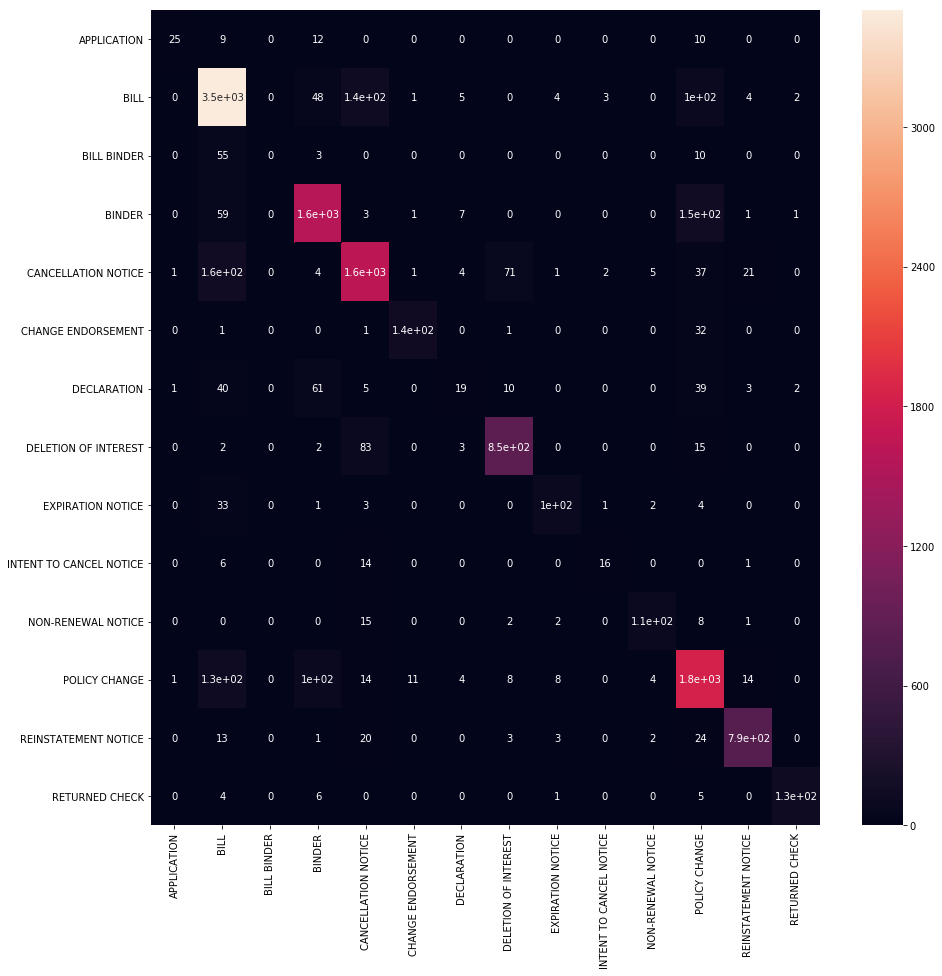

In [38]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(cnf_matrix, index = [i for i in labels],
                  columns = [i for i in labels])
plt.figure(figsize = (15,15))
sn.heatmap(df_cm, annot=True)
plt.show()

In [40]:
from sklearn.metrics import classification_report
print(classification_report(y_test_labels, y_pred_labels))

                         precision    recall  f1-score   support

            APPLICATION       0.89      0.45      0.60        56
                   BILL       0.87      0.92      0.90      3805
            BILL BINDER       0.00      0.00      0.00        68
                 BINDER       0.87      0.88      0.87      1804
    CANCELLATION NOTICE       0.85      0.84      0.85      1944
     CHANGE ENDORSEMENT       0.91      0.80      0.85       175
            DECLARATION       0.45      0.11      0.17       180
   DELETION OF INTEREST       0.90      0.89      0.89       952
      EXPIRATION NOTICE       0.84      0.70      0.76       145
INTENT TO CANCEL NOTICE       0.73      0.43      0.54        37
     NON-RENEWAL NOTICE       0.89      0.79      0.84       136
          POLICY CHANGE       0.81      0.86      0.83      2129
   REINSTATEMENT NOTICE       0.95      0.92      0.93       854
         RETURNED CHECK       0.96      0.89      0.93       147

            avg / total

C:\Users\chara\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [43]:
from sklearn.metrics import cohen_kappa_score
cohen_score = cohen_kappa_score(y_test_labels, y_pred_labels)
cohen_score

0.8318942818149223

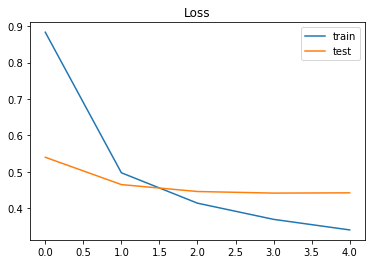

In [28]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

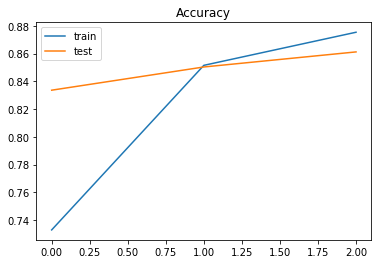

In [235]:
plt.title('Accuracy')
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show();

In [ ]:
# After trying various combinations of hidden layers NN was the best performing model.
# Training loss and accuracy is better than Logistic Regression (Log loss: 0.48781628295878415,Accuracy: 0.8536006596014237)
# Current model (loss: 0.3412, acc: 0.8979)

#### Testing the model

In [20]:
new_complaint = ['cde4f1b2a877 6bf9c0cb01b4 0562c756a2f2 fbb5efbcc5b3 fe081ae57a8b 17bd1f49c9a0 b32153b8b30c 6bf9c0cb01b4 6d1fb90988cf 586242498a88 9ad186d42f69 6b343f522f78 133d46f7ed38 96e70b2e2fc0 6a01047db3ab 40f3a08093c6 ed5d3a65ee2d 6dcc75eaf823 1b6d0614f2c7 3486e5fe0d73 78c3a5c15b68 818a7ff3bf29 578830762b27 d4e08985be1b 2784a2673880 bb11d257e651 7420f0cec354 de4f651eb63b 08cb6a7500f0 5a77390e41f4 d9154c7af554 2b8fa57a48e8 a179031d810a fe081ae57a8b 1015893e384a 5e99d31d8fa4 03ea8eaf674b d06da7343293 ba02159e05b1 892d541c89eb aa1ef5f5355f cf2205dbb077 5071d8aa3768 6b223a390d86 6ce6cc5a3203 b208ae1e8232 efaed70caea1 da8d83a0384e 264341a890cc 1f2955d33eb7 ba3c06a73274 03723393fa70 1015893e384a 586242498a88 1641a72fa752 7d9e333a86da f877ed7dcf49 6bf9c0cb01b4 6b1c8f75a7e2 b32153b8b30c 93790ade6682 a65259ff0092 e432c4501410 b61f1af56200 036087ac04f9 b136f6349cf3 8a3fc46e34c1 6d25574664d2 9cdf4a63deb0 b59e343416f7 d774c0d219f8 3e73b9113504 a457c1b23e3d 0562c756a2f2 0562c756a2f2 93b68f0988ef 4e5019f629a9 eeb86a6a04e4 98d0d51b397c ef237222adfc 1450168c4ac2 22b937b93ed2 f6f466726339 395a5e8185f8 07b4174549d4 b9925442c9c9 8d1bd25011d1 ef4ba44cdf5f 9a42ead47d1c 73801426ea65 0226fe922dd0 8f75273e5510 e1a726bff8dc 3012dd989e4f 95ef80a0b841 7d9e333a86da']
padded = vectorizer.transform(new_complaint)
pred = NN.predict(padded)
labels = y_.columns
print(pred, labels[np.argmax(pred)], max(pred[0]))

[[6.2464970e-08 6.7237274e-06 9.1758778e-09 3.2135224e-05 6.8928660e-03
  8.3735813e-07 1.1964054e-03 9.9150413e-01 5.6751796e-06 4.9102928e-06
  1.6146813e-06 3.5434868e-04 1.7507043e-07 1.7793926e-08]] DELETION OF INTEREST 0.99150413


#### Dumping the model and Loading it

In [73]:
NN.save("nn_model.h5")

In [74]:
from keras.models import load_model

loaded_model = load_model('nn_model.h5')

In [99]:
labels = ['APPLICATION', 'BILL', 'BILL BINDER', 'BINDER', 'CANCELLATION NOTICE','CHANGE ENDORSEMENT', 'DECLARATION', 'DELETION OF INTEREST','EXPIRATION NOTICE', 'INTENT TO CANCEL NOTICE', 'NON-RENEWAL NOTICE','POLICY CHANGE', 'REINSTATEMENT NOTICE', 'RETURNED CHECK']
new_complaint_1 = ['cde4f1b2a877 6bf9c0cb01b4 0562c756a2f2 fbb5efbcc5b3 fe081ae57a8b 17bd1f49c9a0 b32153b8b30c 6bf9c0cb01b4 6d1fb90988cf 586242498a88 9ad186d42f69 6b343f522f78 133d46f7ed38 96e70b2e2fc0 6a01047db3ab 40f3a08093c6 ed5d3a65ee2d 6dcc75eaf823 1b6d0614f2c7 3486e5fe0d73 78c3a5c15b68 818a7ff3bf29 578830762b27 d4e08985be1b 2784a2673880 bb11d257e651 7420f0cec354 de4f651eb63b 08cb6a7500f0 5a77390e41f4 d9154c7af554 2b8fa57a48e8 a179031d810a fe081ae57a8b 1015893e384a 5e99d31d8fa4 03ea8eaf674b d06da7343293 ba02159e05b1 892d541c89eb aa1ef5f5355f cf2205dbb077 5071d8aa3768 6b223a390d86 6ce6cc5a3203 b208ae1e8232 efaed70caea1 da8d83a0384e 264341a890cc 1f2955d33eb7 ba3c06a73274 03723393fa70 1015893e384a 586242498a88 1641a72fa752 7d9e333a86da f877ed7dcf49 6bf9c0cb01b4 6b1c8f75a7e2 b32153b8b30c 93790ade6682 a65259ff0092 e432c4501410 b61f1af56200 036087ac04f9 b136f6349cf3 8a3fc46e34c1 6d25574664d2 9cdf4a63deb0 b59e343416f7 d774c0d219f8 3e73b9113504 a457c1b23e3d 0562c756a2f2 0562c756a2f2 93b68f0988ef 4e5019f629a9 eeb86a6a04e4 98d0d51b397c ef237222adfc 1450168c4ac2 22b937b93ed2 f6f466726339 395a5e8185f8 07b4174549d4 b9925442c9c9 8d1bd25011d1 ef4ba44cdf5f 9a42ead47d1c 73801426ea65 0226fe922dd0 8f75273e5510 e1a726bff8dc 3012dd989e4f 95ef80a0b841 7d9e333a86da']
padded_1 = vectorizer.transform(new_complaint_1)
#labels = y_.columns
pred_1 = loaded_model.predict(padded_1)
print(pred_1, labels[np.argmax(pred_1)], max(pred_1[0]))

[[8.1941773e-11 3.9324896e-06 4.0330440e-11 7.9994847e-05 1.1384566e-02
  2.5012303e-06 1.2878934e-03 9.8701549e-01 5.0460727e-07 1.9047858e-06
  1.1516807e-06 1.9241884e-04 2.1945944e-07 2.9516321e-05]] DELETION OF INTEREST 0.9870155
